# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** Tune-sklearn on PyTorch, Scikit-learn, XGBoost, Keras and LightGBM

</font>
</div>

# Import modules
<hr style="border:2px solid black"> </hr>

In [ ]:
# Skorch example
import numpy as np
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier
from tune_sklearn import TuneGridSearchCV

# Sk-learn example
from tune_sklearn import TuneSearchCV
from tune_sklearn import TuneGridSearchCV
from sklearn.datasets import load_digits
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

# XGBoost example
from tune_sklearn import TuneSearchCV
from sklearn import datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# KERAS example
from keras.datasets import mnist
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from tune_sklearn import TuneGridSearchCV

# LightGBM example
import lightgbm as lgb
from tune_sklearn import TuneSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Getting rid of the warning messages
import warnings
warnings.filterwarnings("ignore")

# What is tune-sklearn?
<hr style="border:2px solid black"> </hr>

<div class="alert alert-block alert-info">
<font color=black>

- Hyperparameters are the parameters of a model which are not updated during training and are used to configure the model or the training function.

- Scikit-Learn provides **natively** two techniques to address hyperparameter tuning: Grid Search (GridSearchCV) and Random Search (RandomizedSearchCV). Though effective, both techniques are brute-force approaches to finding the right hyperparameter configurations, which is an expensive and time-consuming process!

- There are **better** option for hyperparameter tuning:
    - bayesian optimization
    - early stopping
    - distributed execution

- However, the machine learning ecosystem is missing a solution that provides users with the ability to leverage all of the above listed techniques while allowing users to stay within the Scikit-Learn API. In this blog post, we introduce tune-sklearn to bridge this gap. Tune-sklearn is a drop-in replacement for Scikit-Learn’s model selection module with state-of-the-art optimization features.

</font>
</div>

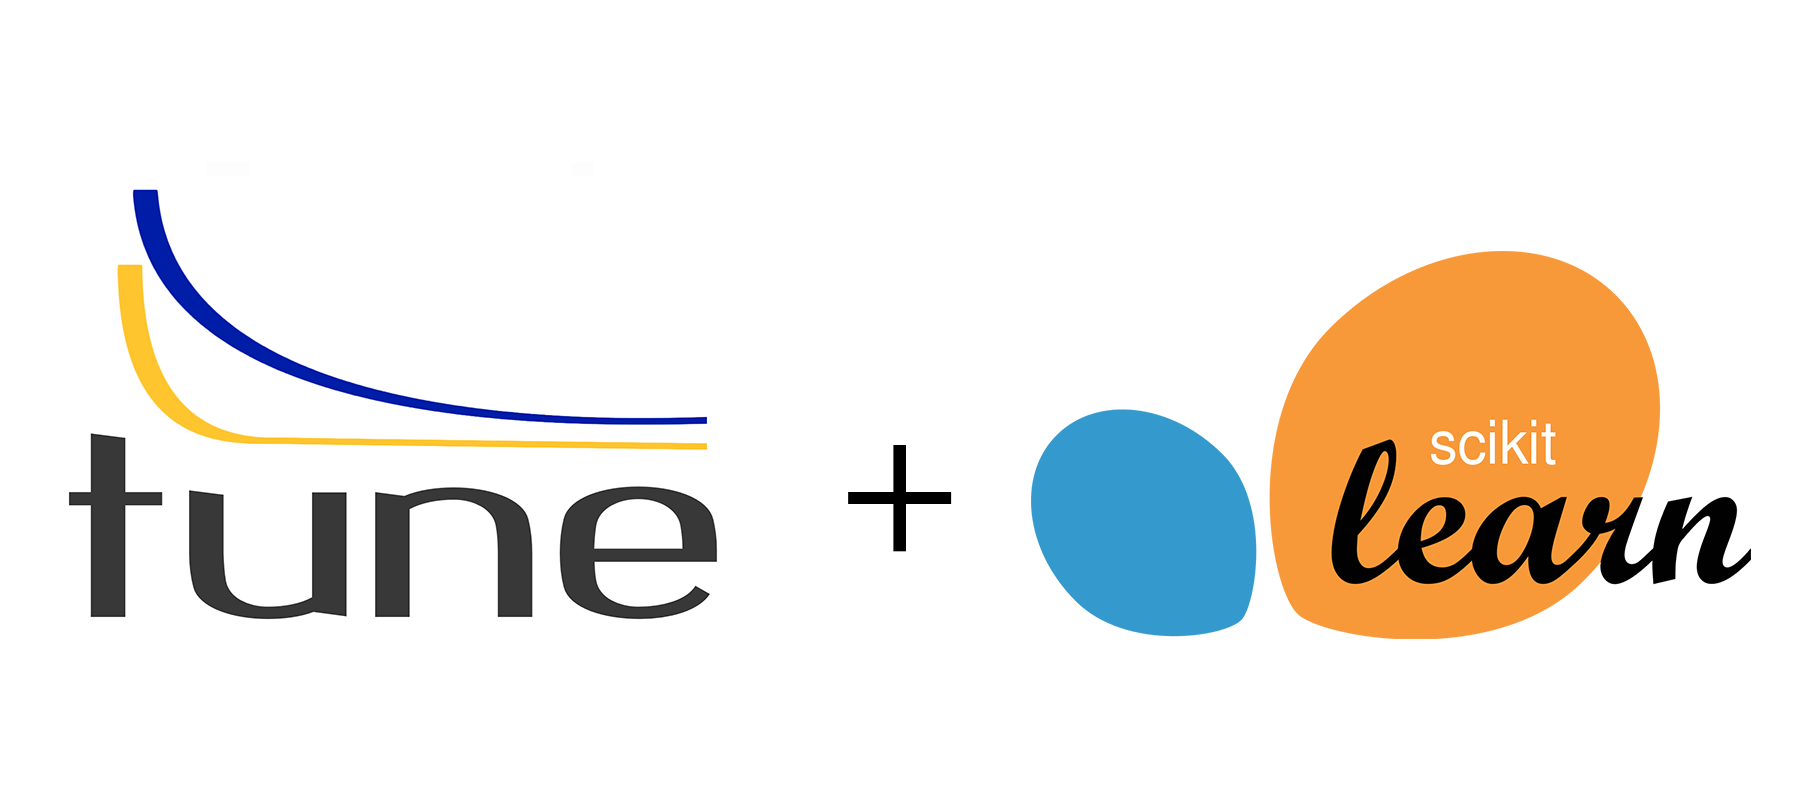

# Skorch + tune-sklearn
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- **Skorch** makes it possible to use tune-sklearn witj PyTorch, hence the name. 
- An example training a PyTorch NeuralNetClassifier, performing grid search using TuneGridSearchCV.
- The NeuralNetClassifier is derived from a scikit-learn compatible neural network library that wraps PyTorch. 
- See more at https://skorch.readthedocs.io/en/stable/index.html

</font>
</div>

In [ ]:
X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)


class MyModule(nn.Module):
    def __init__(self, num_units=10, nonlin=F.relu):
        super(MyModule, self).__init__()
        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X))
        return X


net = NeuralNetClassifier(
    MyModule,
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

params = {
    "lr": [0.01, 0.02],
    "module__num_units": [10, 20],
}

gs = TuneGridSearchCV(net, params, scoring = "accuracy")
gs.fit(X, y)
print(gs.best_score_, gs.best_params_)

# Scikit-Learn + tune-sklearn
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- Example taken and modified from https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html

</font>
</div>

In [ ]:
pipe = Pipeline([
    # the reduce_dim stage is populated by the param_grid
    ("reduce_dim", "passthrough"),
    ("classify", LinearSVC(dual=False, max_iter=10000))
])

N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10]
param_grid = [
    {
        "reduce_dim": [PCA(iterated_power=7), NMF()],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
        "classify__C": C_OPTIONS
    },
    {
        "reduce_dim": [SelectKBest(chi2)],
        "reduce_dim__k": N_FEATURES_OPTIONS,
        "classify__C": C_OPTIONS
    },
]

random = TuneSearchCV(pipe, param_grid, search_optimization="random")
X, y = load_digits(return_X_y=True)
random.fit(X, y)
print(random.cv_results_)

grid = TuneGridSearchCV(pipe, param_grid=param_grid)
grid.fit(X, y)
print(grid.cv_results_)

# XGBoost + tune-sklearn
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- An example training a XGBClassifier, performing randomized search using TuneSearchCV. 

</font>
</div>

In [ ]:
digits = datasets.load_digits()
x = digits.data
y = digits.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

# A parameter grid for XGBoost
params = {
    "min_child_weight": [1, 5, 10],
    "gamma": [0.5, 1, 1.5, 2, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "max_depth": [3, 4, 5],
}

xgb = XGBClassifier(
    learning_rate=0.02,
    n_estimators=50,
    objective="binary:logistic",
    nthread=4,
    # tree_method="gpu_hist"  # this enables GPU.
    # See https://github.com/dmlc/xgboost/issues/2819
)

digit_search = TuneSearchCV(
    xgb,
    param_distributions=params,
    n_trials=3,
    early_stopping=True,
    # use_gpu=True # Commented out for testing on github actions,
    # but this is how you would use gpu
)

digit_search.fit(x_train, y_train)
print(digit_search.best_params_)
print("===", digit_search.cv_results_)

# KerasClassifier + tune-sklearn
<hr style="border:2px solid black"> </hr>

In [ ]:
nb_classes = 10
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[:500]
y_train = y_train[:500]
X_test = X_test[:100]
y_test = y_test[:100]

X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


def create_model(optimizer="rmsprop", kernel_initializer="glorot_uniform"):
    model = Sequential()
    model.add(Dense(512, input_shape=(784, )))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(512, kernel_initializer=kernel_initializer))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(10, kernel_initializer=kernel_initializer))
    model.add(Activation("softmax"))  # This special "softmax" a
    model.compile(
        loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model


model = KerasClassifier(build_fn=create_model)
optimizers = ["rmsprop", "adam"]
kernel_initializer = ["glorot_uniform", "normal"]
epochs = [5, 10]
param_grid = dict(
    optimizer=optimizers,
    nb_epoch=epochs,
    kernel_initializer=kernel_initializer)
grid = TuneGridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, Y_train)
print(grid_result.best_params_)
print("====", grid_result.cv_results_)

# LightGBM + tune-sklearn
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- Example using LightGBM, performing randomized search with TuneSearchCV.
- Example taken from https://mlfromscratch.com/gridsearch-keras-sklearn/#/  

</font>
</div>

In [ ]:
# Load breast cancer dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = lgb.LGBMClassifier()
param_dists = {
    "n_estimators": [400, 700, 1000],
    "colsample_bytree": [0.7, 0.8],
    "max_depth": [15, 20, 25],
    "num_leaves": [50, 100, 200],
    "reg_alpha": [1.1, 1.2, 1.3],
    "reg_lambda": [1.1, 1.2, 1.3],
    "min_split_gain": [0.3, 0.4],
    "subsample": [0.7, 0.8, 0.9],
    "subsample_freq": [20]
}

gs = TuneSearchCV(model, param_dists, n_trials=5, scoring="accuracy")
gs.fit(X_train, y_train)
print(gs.cv_results_)

pred = gs.predict(X_test)
correct = 0
for i in range(len(y_test)):
    if pred[i] == y_test[i]:
        correct += 1
print("Accuracy:", correct / len(pred))

# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- https://medium.com/distributed-computing-with-ray/gridsearchcv-2-0-new-and-improved-ee56644cbabf
- [Skorch example code](https://github.com/ray-project/tune-sklearn/blob/master/examples/torch_nn.py)
- [Scikit-learn example code](https://github.com/ray-project/tune-sklearn/blob/master/examples/sklearn_pipeline.py)
- [XGBoost example code](https://github.com/ray-project/tune-sklearn/blob/master/examples/xgbclassifier.py)
- [Keras example code](https://github.com/ray-project/tune-sklearn/blob/master/examples/keras_example.py)
- [LightGBM](https://github.com/ray-project/tune-sklearn/blob/master/examples/lgbm.py)

</font>
</div>